In [2]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=7cb9ad78b1612fb120daf902fd9b4f471fca599dc8374baa17a695ded36f0c3d
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [3]:
import os, json, glob, re
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from datetime import datetime
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from seqeval.metrics import classification_report as seq_report
from seqeval.metrics import f1_score as seq_f1
from seqeval.metrics import accuracy_score as seq_acc
from seqeval.metrics import precision_score as seq_prec
from seqeval.metrics import recall_score as seq_rec

print("✅ Setup Selesai. GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

2025-12-15 12:23:15.112146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765801395.348361      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765801395.411214      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ Setup Selesai. GPU Available: True


In [4]:
# 1. LOAD DATA
base_path = "/kaggle/input"
json_paths = []

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".json"):
            json_paths.append(os.path.join(root, file))

print(f"📂 Ditemukan {len(json_paths)} file JSON.")

rows = []
for p in tqdm(json_paths, desc="Loading JSON"):
    try:
        with open(p, "r", encoding="utf-8") as f:
            j = json.load(f)
        anns = j.get("annotations", j.get("ann", []))
        rows.append({"text": j.get("text", ""), "ann": anns})
    except Exception as e:
        continue

df = pd.DataFrame(rows)
print(f"✅ Total Dokumen Valid: {len(df)}")

📂 Ditemukan 5029 file JSON.


Loading JSON:   0%|          | 0/5029 [00:00<?, ?it/s]

✅ Total Dokumen Valid: 5029


In [5]:
# 2. BIO TAGGING
def create_bio_tags(text, annotations):
    tokens = text.split()
    labels = ["O"] * len(tokens)
    token_spans = []
    current_idx = 0
    
    for token in tokens:
        start = text.find(token, current_idx)
        end = start + len(token)
        token_spans.append((start, end))
        current_idx = end

    for start_char, end_char, label in annotations:
        for i, (tok_start, tok_end) in enumerate(token_spans):
            if tok_start >= start_char and tok_end <= end_char:
                labels[i] = "B-SKILL" if tok_start == start_char else "I-SKILL"
    return tokens, labels

data_bio = []
for idx, row in df.iterrows():
    ts, ls = create_bio_tags(row['text'], row['ann'])
    if len(ts) > 0:
        data_bio.append({"tokens": ts, "tags": ls})

df_bio = pd.DataFrame(data_bio)
tag2idx = {"O": 0, "B-SKILL": 1, "I-SKILL": 2}
idx2tag = {v: k for k, v in tag2idx.items()}
num_tags = len(tag2idx)
print(f"✅ Data siap format BIO. Jumlah sampel: {len(df_bio)}")

✅ Data siap format BIO. Jumlah sampel: 4982


In [6]:
# 3. DATA PREPARATION
# Tokenizer untuk kata
word_tokenizer = Tokenizer(oov_token="<OOV>")
word_tokenizer.fit_on_texts(df_bio['tokens'])
vocab_size = len(word_tokenizer.word_index) + 1

print(f"📊 Vocabulary size: {vocab_size}")

# Split data
train_docs, test_docs, train_tags, test_tags = train_test_split(
    df_bio['tokens'].tolist(), df_bio['tags'].tolist(), test_size=0.3, random_state=42
)
val_docs, test_docs, val_tags, test_tags = train_test_split(
    test_docs, test_tags, test_size=0.5, random_state=42
)

print(f"\n📊 Data Split:")
print(f"  Train: {len(train_docs)} | Val: {len(val_docs)} | Test: {len(test_docs)}")

📊 Vocabulary size: 186346

📊 Data Split:
  Train: 3487 | Val: 747 | Test: 748


In [7]:
# 4. FUNGSI UNTUK PREPARE DATA DENGAN MAX_LEN TERTENTU
def prepare_data(tokens_list, tags_list, tokenizer, max_len):
    # Sequencing
    X = tokenizer.texts_to_sequences(tokens_list)
    X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')
    
    y = [[tag2idx[t] for t in tags] for tags in tags_list]
    y = pad_sequences(y, maxlen=max_len, padding='post', truncating='post', value=0)
    y_cat = to_categorical(y, num_classes=num_tags)
    
    return X, y_cat

In [8]:
# 5. FUNGSI EVALUASI
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test, verbose=0)
    y_pred_ids = np.argmax(y_pred, axis=-1)
    y_true_ids = np.argmax(y_test, axis=-1)
    
    y_true_seq, y_pred_seq = [], []
    
    for i in range(len(y_true_ids)):
        t_true, t_pred = [], []
        for j in range(len(y_true_ids[i])):
            true_id = y_true_ids[i][j]
            pred_id = y_pred_ids[i][j]
            
            # Skip padding
            if true_id == 0 and j > 0: 
                if np.all(y_true_ids[i][j:] == 0):
                    break
            
            t_true.append(idx2tag[true_id])
            t_pred.append(idx2tag[pred_id])
        
        if t_true:
            y_true_seq.append(t_true)
            y_pred_seq.append(t_pred)
    
    f1 = seq_f1(y_true_seq, y_pred_seq)
    acc = seq_acc(y_true_seq, y_pred_seq)
    prec = seq_prec(y_true_seq, y_pred_seq)
    rec = seq_rec(y_true_seq, y_pred_seq)
    
    return f1, acc, prec, rec

In [9]:
# 6. FUNGSI BUILD MODEL BiGRU
def build_bigru(max_len, vocab_size, embedding_dim, gru_units, dropout_rate, 
                 recurrent_dropout, spatial_dropout):
    inp = layers.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, embedding_dim)(inp)
    x = layers.SpatialDropout1D(spatial_dropout)(x)
    
    x = layers.Bidirectional(
        layers.GRU(gru_units, return_sequences=True, 
                   recurrent_dropout=recurrent_dropout)
    )(x)
    
    x = layers.Dropout(dropout_rate)(x)
    out = layers.TimeDistributed(layers.Dense(num_tags, activation="softmax"))(x)
    
    model = models.Model(inp, out)
    return model

In [10]:
# 7. FUNGSI TRAINING
def train_model(X_train, y_train, X_val, y_val, max_len, learning_rate=0.001, 
                batch_size=32, epochs=10, embedding_dim=128, gru_units=128,
                dropout_rate=0.3, recurrent_dropout=0.1, spatial_dropout=0.1,
                patience=3):
    
    # Clear session
    tf.keras.backend.clear_session()
    
    # Build model BiGRU
    model = build_bigru(
        max_len=max_len,
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        recurrent_dropout=recurrent_dropout,
        spatial_dropout=spatial_dropout
    )
    
    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, 
        loss="categorical_crossentropy", 
        metrics=["accuracy"]
    )
    
    # Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=patience, 
        restore_best_weights=True, 
        verbose=0
    )
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history

In [11]:
# 8. HYPERPARAMETER TUNING SETUP
output_dir = "bigru_tuning_results"
os.makedirs(output_dir, exist_ok=True)

# Default hyperparameters (baseline)
default_params = {
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 10,
    'max_len': 150,
    'embedding_dim': 128,
    'gru_units': 128, 
    'dropout_rate': 0.3,
    'recurrent_dropout': 0.1,
    'spatial_dropout': 0.1,
    'patience': 3
}

# Hyperparameter ranges
param_ranges = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.003, 0.01],
    'batch_size': [16, 32, 64], 
    'max_len': [100, 150, 200, 250], 
    'embedding_dim': [64, 128, 256],
    'gru_units': [64, 128, 256],
    'dropout_rate': [0.1, 0.3, 0.5], 
    'recurrent_dropout': [0.0, 0.1, 0.2], 
    'spatial_dropout': [0.0, 0.1, 0.2]
}

# Prepare base data once
print("\n⚙️ Preparing data dengan max_len default...")
X_train_base, y_train_base = prepare_data(train_docs, train_tags, word_tokenizer, default_params['max_len'])
X_val_base, y_val_base = prepare_data(val_docs, val_tags, word_tokenizer, default_params['max_len'])
X_test_base, y_test_base = prepare_data(test_docs, test_tags, word_tokenizer, default_params['max_len'])

print(f"  X_train shape: {X_train_base.shape}")


⚙️ Preparing data dengan max_len default...
  X_train shape: (3487, 150)


In [12]:
# ==============================================================================
# 🔥 [BARU] STEP 8.5: TRAINING BASELINE MODEL SEBELUM TUNING
# ==============================================================================
print("\n" + "="*70)
print("🏁 TRAINING BASELINE MODEL (DEFAULT PARAMETERS)")
print(f"   Params: {default_params}")
print("="*70)

model_base, history_base = train_model(
    X_train_base, y_train_base, X_val_base, y_val_base,
    max_len=default_params['max_len'],
    learning_rate=default_params['learning_rate'],
    batch_size=default_params['batch_size'],
    epochs=default_params['epochs'],
    embedding_dim=default_params['embedding_dim'],
    gru_units=default_params['gru_units'],
    dropout_rate=default_params['dropout_rate'],
    recurrent_dropout=default_params['recurrent_dropout'],
    spatial_dropout=default_params['spatial_dropout'],
    patience=default_params['patience']
)

# Evaluasi Baseline
f1_base, acc_base, prec_base, rec_base = evaluate_model(model_base, X_val_base, y_val_base)

print(f"\n📊 BASELINE RESULTS (Validation):")
print(f"  → F1: {f1_base:.4f} | Acc: {acc_base:.4f} | Prec: {prec_base:.4f} | Rec: {rec_base:.4f}")

# Simpan hasil baseline sebagai "Best Model" awal
best_overall_f1 = f1_base
best_overall_params = default_params.copy()
best_overall_model = model_base
all_results = {} # Init dictionary hasil

print(f"\n✅ Baseline model selesai. Starting F1 to beat: {best_overall_f1:.4f}")


🏁 TRAINING BASELINE MODEL (DEFAULT PARAMETERS)
   Params: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'max_len': 150, 'embedding_dim': 128, 'gru_units': 128, 'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'spatial_dropout': 0.1, 'patience': 3}


I0000 00:00:1765801453.426925      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765801453.427572      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 77s 589ms/step - accuracy: 0.8127 - loss: 0.5771 - val_accuracy: 0.9262 - val_loss: 0.1928
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 62s 566ms/step - accuracy: 0.9304 - loss: 0.1761 - val_accuracy: 0.9375 - val_loss: 0.1613
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 62s 567ms/step - accuracy: 0.9416 - loss: 0.1445 - val_accuracy: 0.9454 - val_loss: 0.1455
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 564ms/step - accuracy: 0.9549 - loss: 0.1153 - val_accuracy: 0.9498 - val_loss: 0.1405
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 62s 565ms/step - accuracy: 0.9660 - loss: 0.0898 - val_accuracy: 0.9517 - val_loss: 0.1402
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 564ms/step - accuracy: 0.9724 - loss: 0.0747 - val_accuracy: 0.9518 - val_loss: 0.1458
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 562ms/step - accuracy: 0.9781 - loss: 0.0609 - val_accuracy: 0.9525 - val_loss: 0.1545
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 564ms/step - accuracy: 0.9821 - loss: 0

In [13]:
# 9. TUNING SETIAP PARAMETER
print("\n" + "="*70)
print("🚀 MEMULAI HYPERPARAMETER TUNING BiGRU (ONE-AT-A-TIME)")
print("="*70)

for param_name, param_values in param_ranges.items():
    print(f"\n{'='*70}")
    print(f"📊 TUNING PARAMETER: {param_name.upper()}")
    print(f"   Current best params so far: {default_params}")
    print(f"{'='*70}")
    
    param_results = []
    
    for param_value in tqdm(param_values, desc=f"Testing {param_name}"):
        
        # Set current params
        current_params = default_params.copy()
        current_params[param_name] = param_value
        
        print(f"\n  Testing {param_name} = {param_value}")
        
        # Prepare data jika max_len berubah
        if param_name == 'max_len':
            X_train, y_train = prepare_data(train_docs, train_tags, word_tokenizer, param_value)
            X_val, y_val = prepare_data(val_docs, val_tags, word_tokenizer, param_value)
            X_test, y_test = prepare_data(test_docs, test_tags, word_tokenizer, param_value)
        else:
            current_max_len = default_params['max_len']
            if current_max_len != 150:
                X_train, y_train = prepare_data(train_docs, train_tags, word_tokenizer, current_max_len)
                X_val, y_val = prepare_data(val_docs, val_tags, word_tokenizer, current_max_len)
                X_test, y_test = prepare_data(test_docs, test_tags, word_tokenizer, current_max_len)
            else:
                X_train, y_train = X_train_base, y_train_base
                X_val, y_val = X_val_base, y_val_base
                X_test, y_test = X_test_base, y_test_base
        
        # Train model
        model, history = train_model(
            X_train, y_train, X_val, y_val,
            max_len=current_params['max_len'],
            learning_rate=current_params['learning_rate'],
            batch_size=current_params['batch_size'],
            epochs=current_params['epochs'],
            embedding_dim=current_params['embedding_dim'],
            gru_units=current_params['gru_units'], 
            dropout_rate=current_params['dropout_rate'],
            recurrent_dropout=current_params['recurrent_dropout'],
            spatial_dropout=current_params['spatial_dropout'],
            patience=current_params['patience']
        )
        
        # Evaluate on validation set
        f1, acc, prec, rec = evaluate_model(model, X_val, y_val)
        
        print(f"    → F1: {f1:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")
        
        # Store results
        param_results.append({
            'value': param_value,
            'f1': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'val_loss': min(history.history['val_loss']),
            'train_loss': history.history['loss'],
            'val_loss_history': history.history['val_loss'],
            'train_acc': history.history['accuracy'],
            'val_acc': history.history['val_accuracy'],
            'epochs_trained': len(history.history['loss'])
        })
        
        # Check if best overall
        if f1 > best_overall_f1:
            best_overall_f1 = f1
            best_overall_params = current_params.copy()
            best_overall_model = model
            print(f"    ⭐ NEW BEST MODEL! F1: {f1:.4f}")
    
    # Store results for this parameter
    all_results[param_name] = param_results
    
    # UPDATE DEFAULT_PARAMS
    best_idx = np.argmax([r['f1'] for r in param_results])
    best_value_for_param = param_results[best_idx]['value']
    best_f1_for_param = param_results[best_idx]['f1']
    default_params[param_name] = best_value_for_param
    print(f"\n  🔄 UPDATED default_params['{param_name}'] = {best_value_for_param} (F1: {best_f1_for_param:.4f})")
    
    # VISUALISASI
    print(f"\n  📊 Creating plots for {param_name}...")
    for idx, result in enumerate(param_results):
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        param_val = result['value']
        
        # Plot 1: Loss
        ax1 = axes[0, 0]
        epochs_range = range(1, len(result['train_loss']) + 1)
        ax1.plot(epochs_range, result['train_loss'], 'b-o', label='Train Loss')
        ax1.plot(epochs_range, result['val_loss_history'], 'r-s', label='Val Loss')
        ax1.set_title(f'Loss Curve\n{param_name}={param_val}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Accuracy
        ax2 = axes[0, 1]
        ax2.plot(epochs_range, result['train_acc'], 'b-o', label='Train Acc')
        ax2.plot(epochs_range, result['val_acc'], 'r-s', label='Val Acc')
        ax2.set_title(f'Accuracy Curve\n{param_name}={param_val}')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Metrics
        ax3 = axes[1, 0]
        metrics = ['F1', 'Accuracy', 'Precision', 'Recall']
        values = [result['f1'], result['accuracy'], result['precision'], result['recall']]
        bars = ax3.bar(metrics, values, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
        ax3.set_ylim([0, 1.1])
        ax3.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars, values):
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                    f'{val:.4f}', ha='center')
        
        # Plot 4: Summary Text
        ax4 = axes[1, 1]
        ax4.axis('off')
        summary_text = f"SUMMARY - {param_name} = {param_val}\nF1: {result['f1']:.4f}\nEpochs: {result['epochs_trained']}"
        ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, fontsize=12,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.suptitle(f'BiGRU Analysis: {param_name} = {param_val}')
        plt.tight_layout()
        safe_val = str(param_val).replace('.', '_')
        plt.savefig(f"{output_dir}/{param_name}_{safe_val}_detailed.png")
        plt.close()


🚀 MEMULAI HYPERPARAMETER TUNING BiGRU (ONE-AT-A-TIME)

📊 TUNING PARAMETER: LEARNING_RATE
   Current best params so far: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'max_len': 150, 'embedding_dim': 128, 'gru_units': 128, 'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'spatial_dropout': 0.1, 'patience': 3}


Testing learning_rate:   0%|          | 0/5 [00:00<?, ?it/s]


  Testing learning_rate = 0.0001
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 74s 588ms/step - accuracy: 0.7330 - loss: 0.9528 - val_accuracy: 0.8144 - val_loss: 0.5501
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 62s 564ms/step - accuracy: 0.8138 - loss: 0.5174 - val_accuracy: 0.8307 - val_loss: 0.4238
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 62s 566ms/step - accuracy: 0.8460 - loss: 0.3884 - val_accuracy: 0.8875 - val_loss: 0.3110
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 62s 565ms/step - accuracy: 0.8958 - loss: 0.2890 - val_accuracy: 0.9106 - val_loss: 0.2523
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 562ms/step - accuracy: 0.9126 - loss: 0.2392 - val_accuracy: 0.9185 - val_loss: 0.2218
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 564ms/step - accuracy: 0.9204 - loss: 0.2106 - val_accuracy: 0.9254 - val_loss: 0.2033
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 563ms/step - accuracy: 0.9259 - loss: 0.1946 - val_accuracy: 0.9297 - val_loss: 0.1913
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 564ms

Testing batch_size:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing batch_size = 16
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 135s 573ms/step - accuracy: 0.8945 - loss: 0.2801 - val_accuracy: 0.9475 - val_loss: 0.1384
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 123s 563ms/step - accuracy: 0.9600 - loss: 0.1036 - val_accuracy: 0.9543 - val_loss: 0.1278
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 122s 561ms/step - accuracy: 0.9747 - loss: 0.0674 - val_accuracy: 0.9556 - val_loss: 0.1453
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 123s 563ms/step - accuracy: 0.9812 - loss: 0.0512 - val_accuracy: 0.9541 - val_loss: 0.1485
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 123s 562ms/step - accuracy: 0.9807 - loss: 0.0519 - val_accuracy: 0.9516 - val_loss: 0.1584
    → F1: 0.8465 | Acc: 0.9525 | Prec: 0.8133 | Rec: 0.8826
    ⭐ NEW BEST MODEL! F1: 0.8465

  Testing batch_size = 32
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 74s 588ms/step - accuracy: 0.8770 - loss: 0.3399 - val_accuracy: 0.9457 - val_loss: 0.1418
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 62s 566ms/step - accur

Testing max_len:   0%|          | 0/4 [00:00<?, ?it/s]


  Testing max_len = 100
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 93s 389ms/step - accuracy: 0.8982 - loss: 0.2855 - val_accuracy: 0.9498 - val_loss: 0.1368
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 382ms/step - accuracy: 0.9629 - loss: 0.0977 - val_accuracy: 0.9573 - val_loss: 0.1258
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 382ms/step - accuracy: 0.9764 - loss: 0.0653 - val_accuracy: 0.9588 - val_loss: 0.1292
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 381ms/step - accuracy: 0.9798 - loss: 0.0558 - val_accuracy: 0.9569 - val_loss: 0.1408
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 382ms/step - accuracy: 0.9761 - loss: 0.0648 - val_accuracy: 0.9261 - val_loss: 0.2106
    → F1: 0.8595 | Acc: 0.9561 | Prec: 0.8284 | Rec: 0.8930
    ⭐ NEW BEST MODEL! F1: 0.8595

  Testing max_len = 150
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 137s 580ms/step - accuracy: 0.8971 - loss: 0.2807 - val_accuracy: 0.9485 - val_loss: 0.1376
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 124s 568ms/step - accuracy: 0.

Testing embedding_dim:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing embedding_dim = 64
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 92s 384ms/step - accuracy: 0.8931 - loss: 0.2949 - val_accuracy: 0.9521 - val_loss: 0.1335
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 376ms/step - accuracy: 0.9614 - loss: 0.1029 - val_accuracy: 0.9567 - val_loss: 0.1237
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 375ms/step - accuracy: 0.9753 - loss: 0.0671 - val_accuracy: 0.9554 - val_loss: 0.1356
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 375ms/step - accuracy: 0.9808 - loss: 0.0522 - val_accuracy: 0.9597 - val_loss: 0.1429
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 82s 375ms/step - accuracy: 0.9831 - loss: 0.0459 - val_accuracy: 0.9568 - val_loss: 0.1452
    → F1: 0.8569 | Acc: 0.9553 | Prec: 0.8350 | Rec: 0.8800

  Testing embedding_dim = 128
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 393ms/step - accuracy: 0.9001 - loss: 0.2788 - val_accuracy: 0.9528 - val_loss: 0.1342
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 84s 385ms/step - accuracy: 0.9650 - loss: 0.0953 - va

Testing gru_units:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing gru_units = 64
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 391ms/step - accuracy: 0.8962 - loss: 0.2957 - val_accuracy: 0.9531 - val_loss: 0.1357
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 84s 384ms/step - accuracy: 0.9622 - loss: 0.1013 - val_accuracy: 0.9582 - val_loss: 0.1216
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 84s 383ms/step - accuracy: 0.9782 - loss: 0.0602 - val_accuracy: 0.9576 - val_loss: 0.1282
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 382ms/step - accuracy: 0.9833 - loss: 0.0455 - val_accuracy: 0.9588 - val_loss: 0.1411
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 382ms/step - accuracy: 0.9867 - loss: 0.0369 - val_accuracy: 0.9597 - val_loss: 0.1517
    → F1: 0.8600 | Acc: 0.9567 | Prec: 0.8381 | Rec: 0.8831

  Testing gru_units = 128
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 395ms/step - accuracy: 0.8991 - loss: 0.2834 - val_accuracy: 0.9501 - val_loss: 0.1363
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 85s 388ms/step - accuracy: 0.9639 - loss: 0.0975 - val_accura

Testing dropout_rate:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing dropout_rate = 0.1
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 396ms/step - accuracy: 0.9001 - loss: 0.2803 - val_accuracy: 0.9535 - val_loss: 0.1300
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 85s 390ms/step - accuracy: 0.9644 - loss: 0.0946 - val_accuracy: 0.9579 - val_loss: 0.1193
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 85s 388ms/step - accuracy: 0.9777 - loss: 0.0603 - val_accuracy: 0.9574 - val_loss: 0.1292
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 85s 388ms/step - accuracy: 0.9818 - loss: 0.0500 - val_accuracy: 0.9525 - val_loss: 0.1535
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 85s 388ms/step - accuracy: 0.9821 - loss: 0.0488 - val_accuracy: 0.9523 - val_loss: 0.1584
    → F1: 0.8634 | Acc: 0.9564 | Prec: 0.8520 | Rec: 0.8751

  Testing dropout_rate = 0.3
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 395ms/step - accuracy: 0.9007 - loss: 0.2774 - val_accuracy: 0.9521 - val_loss: 0.1330
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 84s 386ms/step - accuracy: 0.9640 - loss: 0.0968 - val

Testing recurrent_dropout:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing recurrent_dropout = 0.0
Epoch 1/10
  1/218 ━━━━━━━━━━━━━━━━━━━━ 21:23 6s/step - accuracy: 0.3263 - loss: 1.0994

I0000 00:00:1765812516.152786     129 cuda_dnn.cc:529] Loaded cuDNN version 90300


218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.8999 - loss: 0.2786 - val_accuracy: 0.9512 - val_loss: 0.1337
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9659 - loss: 0.0902 - val_accuracy: 0.9583 - val_loss: 0.1201
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9796 - loss: 0.0558 - val_accuracy: 0.9590 - val_loss: 0.1321
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9830 - loss: 0.0455 - val_accuracy: 0.9595 - val_loss: 0.1393
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9823 - loss: 0.0482 - val_accuracy: 0.9550 - val_loss: 0.1527
    → F1: 0.8613 | Acc: 0.9564 | Prec: 0.8545 | Rec: 0.8681

  Testing recurrent_dropout = 0.1
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 97s 402ms/step - accuracy: 0.8974 - loss: 0.2807 - val_accuracy: 0.9514 - val_loss: 0.1322
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 86s 393ms/step - accuracy: 0.9641 - loss: 0.0944 - val_accuracy: 0.9583 - val_loss: 0.1209
Epoch 3/

Testing spatial_dropout:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing spatial_dropout = 0.0
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 96s 401ms/step - accuracy: 0.9022 - loss: 0.2703 - val_accuracy: 0.9525 - val_loss: 0.1303
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 86s 393ms/step - accuracy: 0.9654 - loss: 0.0918 - val_accuracy: 0.9585 - val_loss: 0.1211
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 86s 393ms/step - accuracy: 0.9785 - loss: 0.0584 - val_accuracy: 0.9564 - val_loss: 0.1441
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 85s 391ms/step - accuracy: 0.9822 - loss: 0.0477 - val_accuracy: 0.9587 - val_loss: 0.1490
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 86s 393ms/step - accuracy: 0.9795 - loss: 0.0557 - val_accuracy: 0.9257 - val_loss: 0.2265
    → F1: 0.8613 | Acc: 0.9572 | Prec: 0.8398 | Rec: 0.8840

  Testing spatial_dropout = 0.1
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 97s 403ms/step - accuracy: 0.9006 - loss: 0.2805 - val_accuracy: 0.9539 - val_loss: 0.1309
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 86s 394ms/step - accuracy: 0.9641 - loss: 0.0964

In [14]:
# 10. MENYIMPAN HASIL KE CSV
csv_data = []
for param_name, param_results in all_results.items():
    for result in param_results:
        csv_data.append({
            'parameter': param_name,
            'value': result['value'],
            'f1_score': result['f1'],
            'accuracy': result['accuracy'],
            'epochs_trained': result['epochs_trained']
        })

results_df = pd.DataFrame(csv_data)
results_df.to_csv(f"{output_dir}/tuning_results.csv", index=False)
print(f"✅ Saved tuning results to CSV.")

✅ Saved tuning results to CSV.



📊 MEMBUAT VISUALISASI SUMMARY GLOBAL


/tmp/ipykernel_47/3815666004.py:72: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_47/3815666004.py:74: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.savefig(summary_path, dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


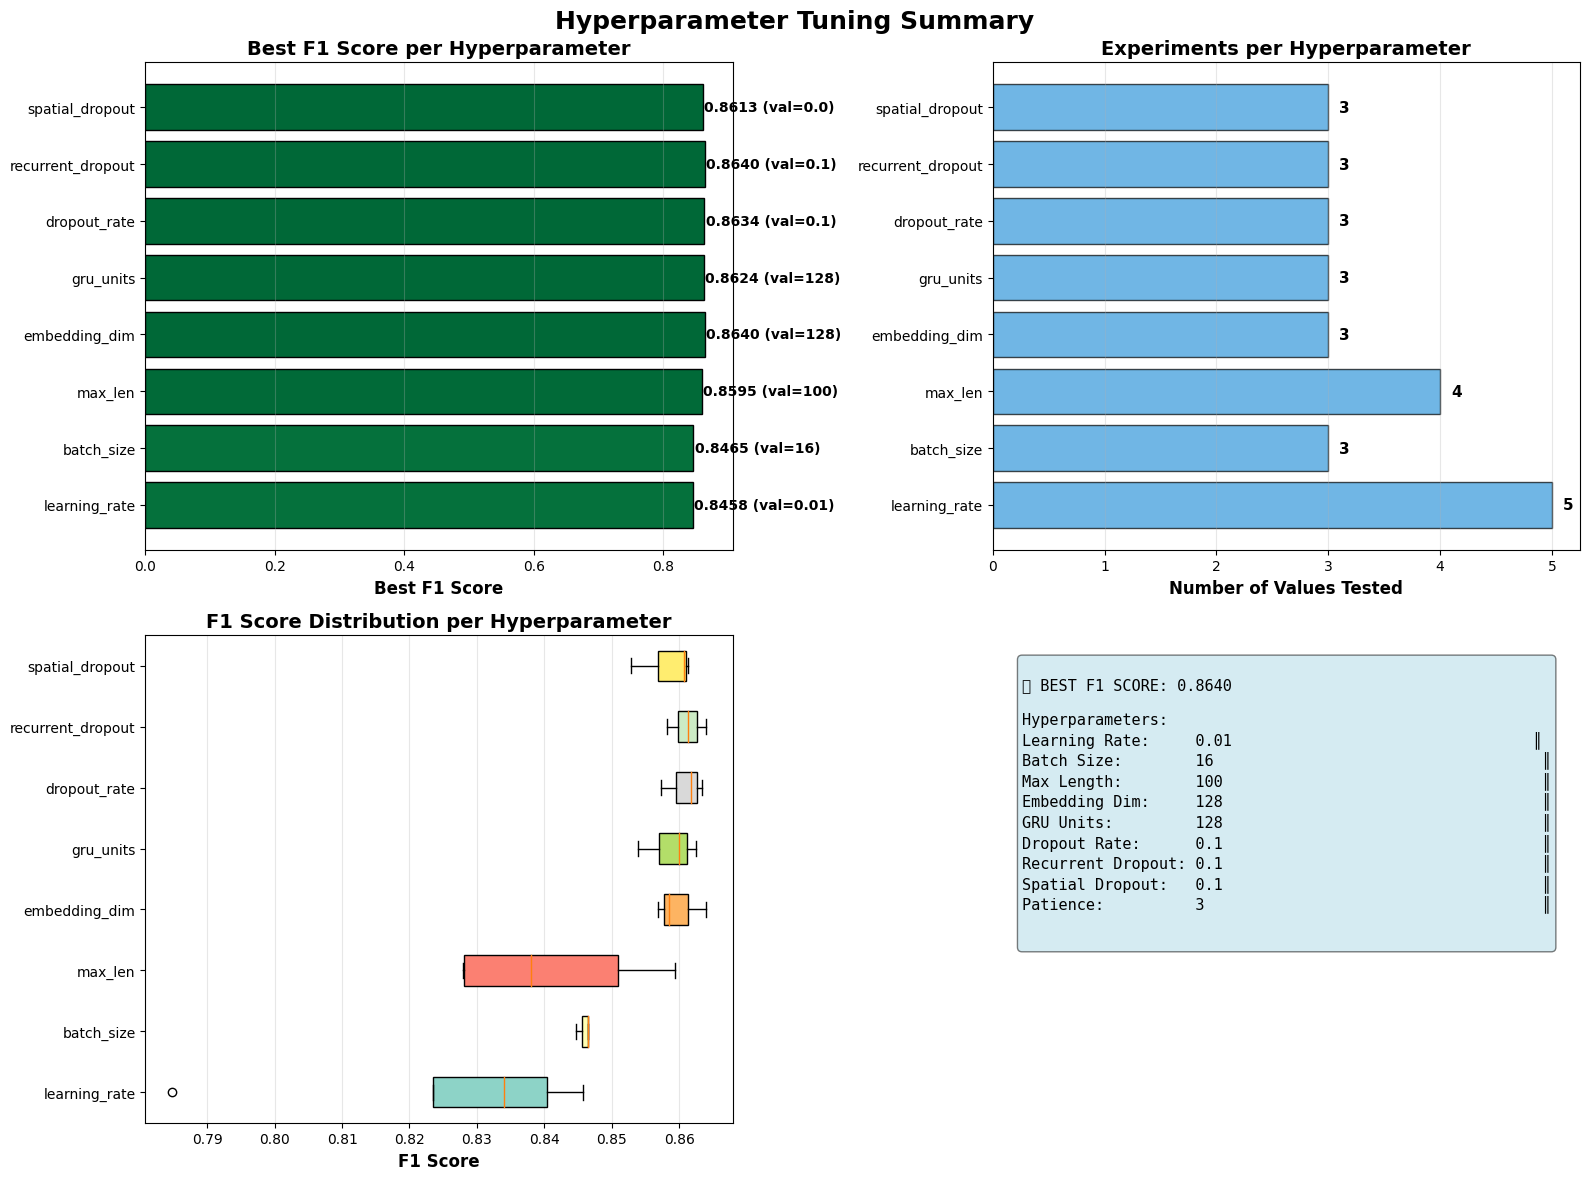

✅ Saved: bigru_tuning_results/tuning_summary_global.png


In [15]:
# 11: VISUALISASI SUMMARY GLOBAL
print("\n" + "="*70)
print("📊 MEMBUAT VISUALISASI SUMMARY GLOBAL")
print("="*70)

# 1. Heatmap - Best F1 per Parameter
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Best F1 Score per Parameter
ax1 = axes[0, 0]
param_names = list(all_results.keys())
best_f1_per_param = [max([r['f1'] for r in all_results[p]]) for p in param_names]
best_values_per_param = []
for p in param_names:
    results = all_results[p]
    best_idx = np.argmax([r['f1'] for r in results])
    best_values_per_param.append(results[best_idx]['value'])

colors = plt.cm.RdYlGn(np.array(best_f1_per_param) / max(best_f1_per_param))
bars = ax1.barh(param_names, best_f1_per_param, color=colors, edgecolor='black')
ax1.set_xlabel('Best F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('Best F1 Score per Hyperparameter', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
for i, (score, val) in enumerate(zip(best_f1_per_param, best_values_per_param)):
    ax1.text(score + 0.002, i, f'{score:.4f} (val={val})', va='center', fontsize=10, fontweight='bold')

# Plot 2: Number of experiments per parameter
ax2 = axes[0, 1]
num_experiments = [len(all_results[p]) for p in param_names]
ax2.barh(param_names, num_experiments, color='#3498db', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Number of Values Tested', fontsize=12, fontweight='bold')
ax2.set_title('Experiments per Hyperparameter', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for i, n in enumerate(num_experiments):
    ax2.text(n + 0.1, i, str(n), va='center', fontsize=11, fontweight='bold')

# Plot 3: F1 Score Distribution (Box Plot per Parameter)
ax3 = axes[1, 0]
f1_data = [[r['f1'] for r in all_results[p]] for p in param_names]
bp = ax3.boxplot(f1_data, labels=param_names, patch_artist=True, vert=False)
colors_box = plt.cm.Set3(np.linspace(0, 1, len(param_names)))
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
ax3.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
ax3.set_title('F1 Score Distribution per Hyperparameter', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Best Overall Configuration Summary
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
🏆 BEST F1 SCORE: {best_overall_f1:.4f}

Hyperparameters:                        
Learning Rate:     {best_overall_params.get('learning_rate', 'N/A')}                                 ║
Batch Size:        {best_overall_params.get('batch_size', 'N/A')}                                    ║
Max Length:        {best_overall_params.get('max_len', 'N/A')}                                   ║
Embedding Dim:     {best_overall_params.get('embedding_dim', 'N/A')}                                   ║
GRU Units:         {best_overall_params.get('gru_units', 'N/A')}                                   ║
Dropout Rate:      {best_overall_params.get('dropout_rate', 'N/A')}                                   ║
Recurrent Dropout: {best_overall_params.get('recurrent_dropout', 'N/A')}                                   ║
Spatial Dropout:   {best_overall_params.get('spatial_dropout', 'N/A')}                                   ║
Patience:          {best_overall_params.get('patience', 'N/A')}                                     ║

"""
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.suptitle('Hyperparameter Tuning Summary', fontsize=18, fontweight='bold')
plt.tight_layout()
summary_path = f"{output_dir}/tuning_summary_global.png"
plt.savefig(summary_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {summary_path}")

In [16]:
# CELL 12: SAVE BEST MODEL & ARTIFACTS
print("\n" + "="*70)
print("💾 MENYIMPAN MODEL TERBAIK & ARTIFACTS (BiGRU)")
print("="*70)

best_model_dir = f"{output_dir}/best_model"
os.makedirs(best_model_dir, exist_ok=True)

# Save Model
best_overall_model.save(f"{best_model_dir}/bigru_ner_best.keras")
best_overall_model.save(f"{best_model_dir}/bigru_ner_best.h5")

# Save Tokenizer
with open(f"{best_model_dir}/word_tokenizer.pkl", 'wb') as f:
    pickle.dump(word_tokenizer, f)

# Save Params
with open(f"{best_model_dir}/best_hyperparameters.json", 'w') as f:
    json.dump(best_overall_params, f, indent=2)

print(f"✅ Model dan artifacts tersimpan di: {best_model_dir}")

# CELL 13: EVALUASI FINAL
X_test_final, y_test_final = prepare_data(
    test_docs, test_tags, word_tokenizer, 
    best_overall_params['max_len']
)

test_f1, test_acc, test_prec, test_rec = evaluate_model(
    best_overall_model, X_test_final, y_test_final
)

print(f"\n📊 HASIL EVALUASI FINAL (BiGRU - TEST SET):")
print(f"  ├─ F1-Score:  {test_f1:.4f}")
print(f"  ├─ Accuracy:  {test_acc:.4f}")
print(f"  ├─ Precision: {test_prec:.4f}")
print(f"  └─ Recall:    {test_rec:.4f}")


💾 MENYIMPAN MODEL TERBAIK & ARTIFACTS (BiGRU)


✅ Model dan artifacts tersimpan di: bigru_tuning_results/best_model

📊 HASIL EVALUASI FINAL (BiGRU - TEST SET):
  ├─ F1-Score:  0.8687
  ├─ Accuracy:  0.9581
  ├─ Precision: 0.8504
  └─ Recall:    0.8878


In [17]:
def build_bilstm(max_len, vocab_size, embedding_dim, lstm_units, dropout_rate, 
                 recurrent_dropout, spatial_dropout):
    inp = layers.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, embedding_dim)(inp)
    x = layers.SpatialDropout1D(spatial_dropout)(x)
    x = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True, 
                   recurrent_dropout=recurrent_dropout)
    )(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.TimeDistributed(layers.Dense(num_tags, activation="softmax"))(x)
    
    model = models.Model(inp, out)
    return model

In [18]:
def train_model(X_train, y_train, X_val, y_val, max_len, learning_rate=0.001, 
                batch_size=32, epochs=10, embedding_dim=128, lstm_units=128,
                dropout_rate=0.3, recurrent_dropout=0.1, spatial_dropout=0.1,
                patience=3):

    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=patience,  # Ini mengambil nilai dari parameter fungsi
    restore_best_weights=True, 
    verbose=0
    )
    
    # Clear session
    tf.keras.backend.clear_session()
    
    # Build model
    model = build_bilstm(
        max_len=max_len,
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        recurrent_dropout=recurrent_dropout,
        spatial_dropout=spatial_dropout
    )
    
    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, 
        loss="categorical_crossentropy", 
        metrics=["accuracy"]
    )
    
    # Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=patience, 
        restore_best_weights=True, 
        verbose=0
    )
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history

In [19]:
# HYPERPARAMETER TUNING SETUP
# Create output directory
output_dir = "bilstm_tuning_results"
os.makedirs(output_dir, exist_ok=True)

# Default hyperparameters (baseline)
default_params = {
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 10,  # Banyak epoch, andalkan early stopping
    'max_len': 150,
    'embedding_dim': 128,
    'lstm_units': 128,
    'dropout_rate': 0.3,
    'recurrent_dropout': 0.1,
    'spatial_dropout': 0.1,
    'patience': 3
}

# Hyperparameter ranges (logis untuk BiLSTM NER)
param_ranges = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.003, 0.01],
    'batch_size': [16, 32, 64], 
    'max_len': [100, 150, 200, 250], 
    'embedding_dim': [64, 128, 256],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.1, 0.3, 0.5], 
    'recurrent_dropout': [0.0, 0.1, 0.2], 
    'spatial_dropout': [0.0, 0.1, 0.2]
}

# Results storage
all_results = {}
best_overall_f1 = 0
best_overall_params = {}
best_overall_model = None

print("\n" + "="*70)
print("🚀 MEMULAI HYPERPARAMETER TUNING BiLSTM (ONE-AT-A-TIME)")
print("="*70)

# Prepare base data once (dengan default max_len)
print("\n⚙️ Preparing data dengan max_len default...")
X_train_base, y_train_base = prepare_data(train_docs, train_tags, word_tokenizer, default_params['max_len'])
X_val_base, y_val_base = prepare_data(val_docs, val_tags, word_tokenizer, default_params['max_len'])
X_test_base, y_test_base = prepare_data(test_docs, test_tags, word_tokenizer, default_params['max_len'])

print(f"  X_train shape: {X_train_base.shape}")
print(f"  X_val shape: {X_val_base.shape}")
print(f"  X_test shape: {X_test_base.shape}")


🚀 MEMULAI HYPERPARAMETER TUNING BiLSTM (ONE-AT-A-TIME)

⚙️ Preparing data dengan max_len default...
  X_train shape: (3487, 150)
  X_val shape: (747, 150)
  X_test shape: (748, 150)


In [20]:
# TUNING SETIAP PARAMETER (WITH SEQUENTIAL UPDATE)
for param_name, param_values in param_ranges.items():
    print(f"\n{'='*70}")
    print(f"📊 TUNING PARAMETER: {param_name.upper()}")
    print(f"   Current base params: {default_params}")
    print(f"{'='*70}")
    
    param_results = []
    
    for param_value in tqdm(param_values, desc=f"Testing {param_name}"):
        # Set current params (dari default_params yang sudah di-update)
        current_params = default_params.copy()
        current_params[param_name] = param_value
        
        print(f"\n  Testing {param_name} = {param_value}")
        
        # Jika tuning max_len, perlu re-prepare data
        if param_name == 'max_len':
            X_train, y_train = prepare_data(train_docs, train_tags, word_tokenizer, param_value)
            X_val, y_val = prepare_data(val_docs, val_tags, word_tokenizer, param_value)
            X_test, y_test = prepare_data(test_docs, test_tags, word_tokenizer, param_value)
        else:
            # Gunakan data dengan max_len dari default_params (yang mungkin sudah di-update)
            current_max_len = default_params['max_len']
            if current_max_len != 150:  # 150 adalah default awal
                X_train, y_train = prepare_data(train_docs, train_tags, word_tokenizer, current_max_len)
                X_val, y_val = prepare_data(val_docs, val_tags, word_tokenizer, current_max_len)
                X_test, y_test = prepare_data(test_docs, test_tags, word_tokenizer, current_max_len)
            else:
                X_train, y_train = X_train_base, y_train_base
                X_val, y_val = X_val_base, y_val_base
                X_test, y_test = X_test_base, y_test_base
        
        # Train model
        model, history = train_model(
            X_train, y_train, X_val, y_val,
            max_len=current_params['max_len'],
            learning_rate=current_params['learning_rate'],
            batch_size=current_params['batch_size'],
            epochs=current_params['epochs'],
            embedding_dim=current_params['embedding_dim'],
            lstm_units=current_params['lstm_units'],
            dropout_rate=current_params['dropout_rate'],
            recurrent_dropout=current_params['recurrent_dropout'],
            spatial_dropout=current_params['spatial_dropout'],
            patience=current_params['patience']
        )
        
        # Evaluate on validation set
        f1, acc, prec, rec = evaluate_model(model, X_val, y_val)
        
        print(f"    → F1: {f1:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")
        
        # Store results
        param_results.append({
            'value': param_value,
            'f1': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'val_loss': min(history.history['val_loss']),
            'train_loss': history.history['loss'],
            'val_loss_history': history.history['val_loss'],
            'train_acc': history.history['accuracy'],
            'val_acc': history.history['val_accuracy'],
            'epochs_trained': len(history.history['loss'])
        })
        
        # Check if best overall
        if f1 > best_overall_f1:
            best_overall_f1 = f1
            best_overall_params = current_params.copy()
            best_overall_model = model
            print(f"    ⭐ NEW BEST MODEL! F1: {f1:.4f}")
    
    # Store results for this parameter
    all_results[param_name] = param_results
    
    # ===================================================================
    # 🔥 UPDATE DEFAULT_PARAMS DENGAN NILAI TERBAIK DARI PARAMETER INI
    # ===================================================================
    best_idx = np.argmax([r['f1'] for r in param_results])
    best_value_for_param = param_results[best_idx]['value']
    best_f1_for_param = param_results[best_idx]['f1']
    default_params[param_name] = best_value_for_param
    print(f"\n  🔄 UPDATED default_params['{param_name}'] = {best_value_for_param} (F1: {best_f1_for_param:.4f})")
    print(f"  📋 Current default_params: {default_params}")
    
    # ===================================================================
    # VISUALISASI DETAIL PER PARAMETER (TERPISAH PER VARIAN)
    # ===================================================================
    
    # 1. PLOT TRAINING HISTORY (LOSS & ACC CURVES) - SATU PLOT PER VARIAN
    print(f"\n  📊 Creating training history plots for {param_name}...")
    for idx, result in enumerate(param_results):
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        param_val = result['value']
        
        # Plot 1: Training & Validation Loss
        ax1 = axes[0, 0]
        epochs_range = range(1, len(result['train_loss']) + 1)
        ax1.plot(epochs_range, result['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
        ax1.plot(epochs_range, result['val_loss_history'], 'r-s', label='Val Loss', linewidth=2, markersize=6)
        ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
        ax1.set_title(f'Loss Curve\n{param_name}={param_val}', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Highlight early stopping point
        ax1.axvline(x=result['epochs_trained'], color='green', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f'Stopped at epoch {result["epochs_trained"]}')
        ax1.legend(fontsize=10)
        
        # Plot 2: Training & Validation Accuracy
        ax2 = axes[0, 1]
        ax2.plot(epochs_range, result['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=6)
        ax2.plot(epochs_range, result['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax2.set_title(f'Accuracy Curve\n{param_name}={param_val}', fontsize=13, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        ax2.axvline(x=result['epochs_trained'], color='green', linestyle='--', 
                   linewidth=2, alpha=0.7)
        
        # Plot 3: Performance Metrics Bar
        ax3 = axes[1, 0]
        metrics = ['F1', 'Accuracy', 'Precision', 'Recall']
        values = [result['f1'], result['accuracy'], result['precision'], result['recall']]
        colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
        bars = ax3.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax3.set_title(f'Performance Metrics\n{param_name}={param_val}', fontsize=13, fontweight='bold')
        ax3.set_ylim([0, 1.1])
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # Plot 4: Summary Info (Text)
        ax4 = axes[1, 1]
        ax4.axis('off')
        
        summary_text = f"""
        SUMMARY - {param_name.replace('_', ' ').upper()} = {param_val}
        {'='*50}
        
        Training Information:
        - Total Epochs Trained: {result['epochs_trained']}
        - Early Stopped: {'Yes' if result['epochs_trained'] < current_params['epochs'] else 'No'}
        
        Loss Metrics:
        - Final Train Loss: {result['train_loss'][-1]:.6f}
        - Final Val Loss:   {result['val_loss_history'][-1]:.6f}
        - Min Val Loss:     {result['val_loss']:.6f}
        - Overfitting Gap:  {abs(result['train_loss'][-1] - result['val_loss_history'][-1]):.6f}
        
        Accuracy Metrics:
        - Final Train Acc:  {result['train_acc'][-1]:.4f}
        - Final Val Acc:    {result['val_acc'][-1]:.4f}
        
        Performance Metrics:
        - F1-Score:   {result['f1']:.4f}
        - Accuracy:   {result['accuracy']:.4f}
        - Precision:  {result['precision']:.4f}
        - Recall:     {result['recall']:.4f}
        
        Configuration:
        - Learning Rate:      {current_params['learning_rate']}
        - Batch Size:         {current_params['batch_size']}
        - Max Length:         {current_params['max_len']}
        - Embedding Dim:      {current_params['embedding_dim']}
        - LSTM Units:         {current_params['lstm_units']}
        - Dropout:            {current_params['dropout_rate']}
        - Recurrent Dropout:  {current_params['recurrent_dropout']}
        - Spatial Dropout:    {current_params['spatial_dropout']}
        - Patience:           {current_params['patience']}
        """
        
        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
                fontsize=9, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.suptitle(f'Detailed Analysis: {param_name.replace("_", " ").title()} = {param_val}',
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        # Save plot
        safe_param_val = str(param_val).replace('.', '_').replace('-', 'neg')
        plot_path = f"{output_dir}/{param_name}_value_{safe_param_val}_detailed.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"    ✅ Saved: {plot_path}")
    
    # 2. PLOT COMPARISON ACROSS ALL VALUES OF THIS PARAMETER
    print(f"\n  📊 Creating comparison plot for {param_name}...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    values = [r['value'] for r in param_results]
    
    # Plot 1: F1-Score comparison
    ax = axes[0, 0]
    f1_scores = [r['f1'] for r in param_results]
    bars = ax.bar(range(len(values)), f1_scores, color='#2ecc71', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('F1-Score Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    best_idx = np.argmax(f1_scores)
    bars[best_idx].set_color('red')
    bars[best_idx].set_alpha(1.0)
    for i, score in enumerate(f1_scores):
        ax.text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 2: Accuracy comparison
    ax = axes[0, 1]
    acc_scores = [r['accuracy'] for r in param_results]
    bars = ax.bar(range(len(values)), acc_scores, color='#3498db', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    best_idx = np.argmax(acc_scores)
    bars[best_idx].set_color('red')
    bars[best_idx].set_alpha(1.0)
    for i, score in enumerate(acc_scores):
        ax.text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 3: Precision comparison
    ax = axes[0, 2]
    prec_scores = [r['precision'] for r in param_results]
    bars = ax.bar(range(len(values)), prec_scores, color='#e74c3c', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax.set_title('Precision Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    best_idx = np.argmax(prec_scores)
    bars[best_idx].set_color('red')
    bars[best_idx].set_alpha(1.0)
    for i, score in enumerate(prec_scores):
        ax.text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Recall comparison
    ax = axes[1, 0]
    rec_scores = [r['recall'] for r in param_results]
    bars = ax.bar(range(len(values)), rec_scores, color='#f39c12', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Recall', fontsize=12, fontweight='bold')
    ax.set_title('Recall Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    best_idx = np.argmax(rec_scores)
    bars[best_idx].set_color('red')
    bars[best_idx].set_alpha(1.0)
    for i, score in enumerate(rec_scores):
        ax.text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 5: Min Validation Loss comparison
    ax = axes[1, 1]
    val_losses = [r['val_loss'] for r in param_results]
    bars = ax.bar(range(len(values)), val_losses, color='#9b59b6', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Min Validation Loss', fontsize=12, fontweight='bold')
    ax.set_title('Validation Loss Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    best_idx = np.argmin(val_losses)
    bars[best_idx].set_color('green')
    bars[best_idx].set_alpha(1.0)
    for i, loss in enumerate(val_losses):
        ax.text(i, loss + 0.002, f'{loss:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 6: Epochs Trained comparison
    ax = axes[1, 2]
    epochs_trained = [r['epochs_trained'] for r in param_results]
    bars = ax.bar(range(len(values)), epochs_trained, color='#1abc9c', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Epochs Trained', fontsize=12, fontweight='bold')
    ax.set_title('Training Duration (Epochs)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=current_params['epochs'], color='red', linestyle='--', 
               linewidth=2, alpha=0.5, label=f'Max Epochs ({current_params["epochs"]})')
    ax.legend()
    for i, ep in enumerate(epochs_trained):
        ax.text(i, ep + 0.3, f'{ep}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle(f'Performance Comparison: {param_name.replace("_", " ").title()}',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    comparison_path = f"{output_dir}/{param_name}_comparison_all_metrics.png"
    plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"    ✅ Saved: {comparison_path}")

# Print final updated params
print(f"\n{'='*70}")
print("✅ TUNING SELESAI! FINAL DEFAULT_PARAMS (UPDATED):")
print(f"{'='*70}")
for k, v in default_params.items():
    print(f"  • {k}: {v}")


📊 TUNING PARAMETER: LEARNING_RATE
   Current base params: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'max_len': 150, 'embedding_dim': 128, 'lstm_units': 128, 'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'spatial_dropout': 0.1, 'patience': 3}


Testing learning_rate:   0%|          | 0/5 [00:00<?, ?it/s]


  Testing learning_rate = 0.0001
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 82s 652ms/step - accuracy: 0.7438 - loss: 0.9366 - val_accuracy: 0.8144 - val_loss: 0.5581
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 69s 629ms/step - accuracy: 0.8141 - loss: 0.5500 - val_accuracy: 0.8144 - val_loss: 0.5155
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 68s 627ms/step - accuracy: 0.8140 - loss: 0.5043 - val_accuracy: 0.8234 - val_loss: 0.4440
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 69s 629ms/step - accuracy: 0.8350 - loss: 0.4201 - val_accuracy: 0.8721 - val_loss: 0.3418
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 68s 628ms/step - accuracy: 0.8805 - loss: 0.3245 - val_accuracy: 0.9034 - val_loss: 0.2723
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 69s 630ms/step - accuracy: 0.9057 - loss: 0.2651 - val_accuracy: 0.9158 - val_loss: 0.2395
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 68s 629ms/step - accuracy: 0.9164 - loss: 0.2317 - val_accuracy: 0.9209 - val_loss: 0.2209
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 68s 625ms

Testing batch_size:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing batch_size = 16
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 147s 627ms/step - accuracy: 0.8853 - loss: 0.3280 - val_accuracy: 0.9464 - val_loss: 0.1406
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 134s 617ms/step - accuracy: 0.9547 - loss: 0.1156 - val_accuracy: 0.9531 - val_loss: 0.1264
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 134s 616ms/step - accuracy: 0.9740 - loss: 0.0683 - val_accuracy: 0.9564 - val_loss: 0.1334
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 134s 616ms/step - accuracy: 0.9816 - loss: 0.0481 - val_accuracy: 0.9541 - val_loss: 0.1495
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 134s 616ms/step - accuracy: 0.9868 - loss: 0.0350 - val_accuracy: 0.9572 - val_loss: 0.1613
    → F1: 0.8442 | Acc: 0.9512 | Prec: 0.8096 | Rec: 0.8818

  Testing batch_size = 32
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 79s 636ms/step - accuracy: 0.8436 - loss: 0.4345 - val_accuracy: 0.9389 - val_loss: 0.1575
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 67s 615ms/step - accuracy: 0.9466 - loss: 0.1331 - val_

Testing max_len:   0%|          | 0/4 [00:00<?, ?it/s]


  Testing max_len = 100
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 56s 439ms/step - accuracy: 0.8505 - loss: 0.4183 - val_accuracy: 0.9450 - val_loss: 0.1481
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 46s 423ms/step - accuracy: 0.9552 - loss: 0.1173 - val_accuracy: 0.9543 - val_loss: 0.1251
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 46s 424ms/step - accuracy: 0.9712 - loss: 0.0761 - val_accuracy: 0.9590 - val_loss: 0.1221
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 46s 422ms/step - accuracy: 0.9819 - loss: 0.0490 - val_accuracy: 0.9590 - val_loss: 0.1300
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 46s 421ms/step - accuracy: 0.9868 - loss: 0.0359 - val_accuracy: 0.9603 - val_loss: 0.1494
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 46s 420ms/step - accuracy: 0.9908 - loss: 0.0258 - val_accuracy: 0.9605 - val_loss: 0.1665
    → F1: 0.8663 | Acc: 0.9579 | Prec: 0.8410 | Rec: 0.8932
    ⭐ NEW BEST MODEL! F1: 0.8663

  Testing max_len = 150
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 81s 647ms/step - accuracy: 0.85

Testing embedding_dim:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing embedding_dim = 64
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 55s 430ms/step - accuracy: 0.8553 - loss: 0.4219 - val_accuracy: 0.9441 - val_loss: 0.1548
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 45s 415ms/step - accuracy: 0.9497 - loss: 0.1319 - val_accuracy: 0.9526 - val_loss: 0.1325
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 45s 414ms/step - accuracy: 0.9679 - loss: 0.0867 - val_accuracy: 0.9573 - val_loss: 0.1282
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 45s 411ms/step - accuracy: 0.9785 - loss: 0.0588 - val_accuracy: 0.9576 - val_loss: 0.1329
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 45s 412ms/step - accuracy: 0.9857 - loss: 0.0401 - val_accuracy: 0.9585 - val_loss: 0.1452
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 45s 412ms/step - accuracy: 0.9888 - loss: 0.0311 - val_accuracy: 0.9589 - val_loss: 0.1629
    → F1: 0.8599 | Acc: 0.9559 | Prec: 0.8367 | Rec: 0.8844

  Testing embedding_dim = 128
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 57s 441ms/step - accuracy: 0.8420 - loss: 0.4376 - va

Testing lstm_units:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing lstm_units = 64
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - accuracy: 0.8675 - loss: 0.3631 - val_accuracy: 0.9488 - val_loss: 0.1430
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 437ms/step - accuracy: 0.9556 - loss: 0.1175 - val_accuracy: 0.9566 - val_loss: 0.1236
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 47s 433ms/step - accuracy: 0.9745 - loss: 0.0689 - val_accuracy: 0.9600 - val_loss: 0.1253
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 47s 434ms/step - accuracy: 0.9820 - loss: 0.0484 - val_accuracy: 0.9607 - val_loss: 0.1385
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 47s 432ms/step - accuracy: 0.9877 - loss: 0.0339 - val_accuracy: 0.9604 - val_loss: 0.1507
    → F1: 0.8562 | Acc: 0.9553 | Prec: 0.8314 | Rec: 0.8825

  Testing lstm_units = 128
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 58s 453ms/step - accuracy: 0.8465 - loss: 0.4104 - val_accuracy: 0.9450 - val_loss: 0.1517
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 436ms/step - accuracy: 0.9534 - loss: 0.1238 - val_accu

Testing dropout_rate:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing dropout_rate = 0.1
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 60s 464ms/step - accuracy: 0.8239 - loss: 0.6206 - val_accuracy: 0.9401 - val_loss: 0.1619
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 445ms/step - accuracy: 0.9440 - loss: 0.1430 - val_accuracy: 0.9480 - val_loss: 0.1421
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 446ms/step - accuracy: 0.9570 - loss: 0.1117 - val_accuracy: 0.9527 - val_loss: 0.1312
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 444ms/step - accuracy: 0.9694 - loss: 0.0818 - val_accuracy: 0.9568 - val_loss: 0.1256
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 441ms/step - accuracy: 0.9778 - loss: 0.0597 - val_accuracy: 0.9570 - val_loss: 0.1310
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 441ms/step - accuracy: 0.9845 - loss: 0.0420 - val_accuracy: 0.9611 - val_loss: 0.1349
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 48s 440ms/step - accuracy: 0.9883 - loss: 0.0318 - val_accuracy: 0.9587 - val_loss: 0.1511
    → F1: 0.8595 | Acc: 0.9552 | Prec: 0.8390 | Rec: 

Testing recurrent_dropout:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing recurrent_dropout = 0.0
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.8242 - loss: 0.6091 - val_accuracy: 0.9431 - val_loss: 0.1548
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9491 - loss: 0.1319 - val_accuracy: 0.9520 - val_loss: 0.1324
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9634 - loss: 0.0960 - val_accuracy: 0.9564 - val_loss: 0.1273
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9763 - loss: 0.0626 - val_accuracy: 0.9592 - val_loss: 0.1269
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9838 - loss: 0.0432 - val_accuracy: 0.9600 - val_loss: 0.1387
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9876 - loss: 0.0337 - val_accuracy: 0.9594 - val_loss: 0.1545
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9917 - loss: 0.0233 - val_accuracy: 0.9603 - val_loss: 0.1676
    → F1: 0.8644 | Acc: 0.9576 | Prec: 0.8545 | Rec: 0.8746



Testing spatial_dropout:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing spatial_dropout = 0.0
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.8257 - loss: 0.5920 - val_accuracy: 0.9427 - val_loss: 0.1580
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9483 - loss: 0.1341 - val_accuracy: 0.9509 - val_loss: 0.1369
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9638 - loss: 0.0958 - val_accuracy: 0.9562 - val_loss: 0.1315
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9746 - loss: 0.0681 - val_accuracy: 0.9579 - val_loss: 0.1320
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9818 - loss: 0.0487 - val_accuracy: 0.9600 - val_loss: 0.1417
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9871 - loss: 0.0355 - val_accuracy: 0.9603 - val_loss: 0.1522
    → F1: 0.8558 | Acc: 0.9552 | Prec: 0.8218 | Rec: 0.8927

  Testing spatial_dropout = 0.1
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.8211 - loss: 0.6194 - val_accur


📊 MEMBUAT VISUALISASI SUMMARY GLOBAL


/tmp/ipykernel_47/3084757315.py:70: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_47/3084757315.py:72: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.savefig(summary_path, dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


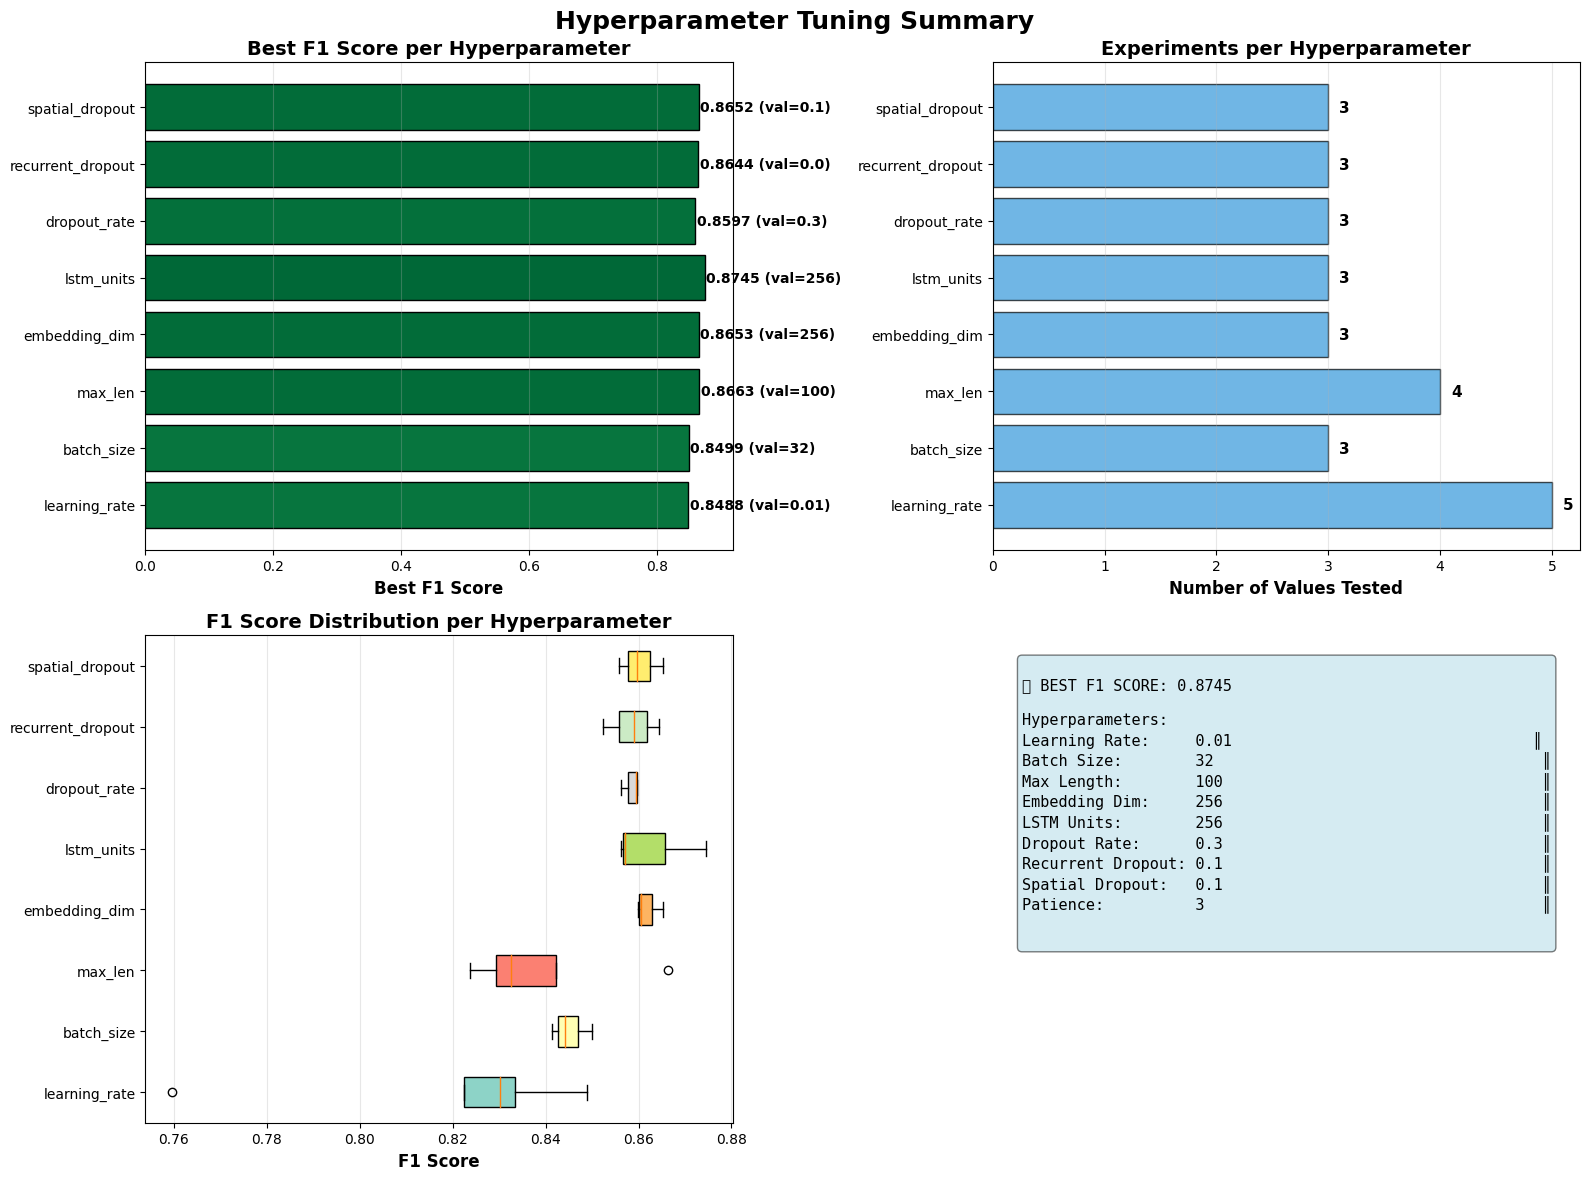

✅ Saved: bilstm_tuning_results/tuning_summary_global.png


In [21]:
print("\n" + "="*70)
print("📊 MEMBUAT VISUALISASI SUMMARY GLOBAL")
print("="*70)

# 1. Heatmap - Best F1 per Parameter
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Best F1 Score per Parameter
ax1 = axes[0, 0]
param_names = list(all_results.keys())
best_f1_per_param = [max([r['f1'] for r in all_results[p]]) for p in param_names]
best_values_per_param = []
for p in param_names:
    results = all_results[p]
    best_idx = np.argmax([r['f1'] for r in results])
    best_values_per_param.append(results[best_idx]['value'])

colors = plt.cm.RdYlGn(np.array(best_f1_per_param) / max(best_f1_per_param))
bars = ax1.barh(param_names, best_f1_per_param, color=colors, edgecolor='black')
ax1.set_xlabel('Best F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('Best F1 Score per Hyperparameter', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
for i, (score, val) in enumerate(zip(best_f1_per_param, best_values_per_param)):
    ax1.text(score + 0.002, i, f'{score:.4f} (val={val})', va='center', fontsize=10, fontweight='bold')

# Plot 2: Number of experiments per parameter
ax2 = axes[0, 1]
num_experiments = [len(all_results[p]) for p in param_names]
ax2.barh(param_names, num_experiments, color='#3498db', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Number of Values Tested', fontsize=12, fontweight='bold')
ax2.set_title('Experiments per Hyperparameter', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for i, n in enumerate(num_experiments):
    ax2.text(n + 0.1, i, str(n), va='center', fontsize=11, fontweight='bold')

# Plot 3: F1 Score Distribution (Box Plot per Parameter)
ax3 = axes[1, 0]
f1_data = [[r['f1'] for r in all_results[p]] for p in param_names]
bp = ax3.boxplot(f1_data, labels=param_names, patch_artist=True, vert=False)
colors_box = plt.cm.Set3(np.linspace(0, 1, len(param_names)))
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
ax3.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
ax3.set_title('F1 Score Distribution per Hyperparameter', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Best Overall Configuration Summary
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
🏆 BEST F1 SCORE: {best_overall_f1:.4f}

Hyperparameters:                       
Learning Rate:     {best_overall_params.get('learning_rate', 'N/A')}                                 ║
Batch Size:        {best_overall_params.get('batch_size', 'N/A')}                                    ║
Max Length:        {best_overall_params.get('max_len', 'N/A')}                                   ║
Embedding Dim:     {best_overall_params.get('embedding_dim', 'N/A')}                                   ║
LSTM Units:        {best_overall_params.get('lstm_units', 'N/A')}                                   ║
Dropout Rate:      {best_overall_params.get('dropout_rate', 'N/A')}                                   ║
Recurrent Dropout: {best_overall_params.get('recurrent_dropout', 'N/A')}                                   ║
Spatial Dropout:   {best_overall_params.get('spatial_dropout', 'N/A')}                                   ║
Patience:          {best_overall_params.get('patience', 'N/A')}                                     ║

"""
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.suptitle('Hyperparameter Tuning Summary', fontsize=18, fontweight='bold')
plt.tight_layout()
summary_path = f"{output_dir}/tuning_summary_global.png"
plt.savefig(summary_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {summary_path}")

In [22]:
# CELL 12: SAVE BEST MODEL & ARTIFACTS
print("\n" + "="*70)
print("💾 MENYIMPAN MODEL TERBAIK & ARTIFACTS")
print("="*70)

# Create best model directory
best_model_dir = f"{output_dir}/best_model"
os.makedirs(best_model_dir, exist_ok=True)

# 1. Save Model (Keras format)
model_path = f"{best_model_dir}/bilstm_ner_best.keras"
best_overall_model.save(model_path)
print(f"✅ Model saved: {model_path}")

# 2. Save Model (H5 format - legacy)
model_h5_path = f"{best_model_dir}/bilstm_ner_best.h5"
best_overall_model.save(model_h5_path)
print(f"✅ Model H5 saved: {model_h5_path}")

# 3. Save Tokenizer
tokenizer_path = f"{best_model_dir}/word_tokenizer.pkl"
with open(tokenizer_path, 'wb') as f:
    pickle.dump(word_tokenizer, f)
print(f"✅ Tokenizer saved: {tokenizer_path}")

# 4. Save Tag Mappings
tag_mappings = {
    'tag2idx': tag2idx,
    'idx2tag': idx2tag,
    'num_tags': num_tags
}
tag_path = f"{best_model_dir}/tag_mappings.pkl"
with open(tag_path, 'wb') as f:
    pickle.dump(tag_mappings, f)
print(f"✅ Tag mappings saved: {tag_path}")

# 5. Save Best Hyperparameters
params_path = f"{best_model_dir}/best_hyperparameters.json"
with open(params_path, 'w') as f:
    json.dump(best_overall_params, f, indent=2)
print(f"✅ Best hyperparameters saved: {params_path}")

# 6. Save Metadata
metadata = {
    'best_f1_score': float(best_overall_f1),
    'vocab_size': vocab_size,
    'num_tags': num_tags,
    'tag2idx': tag2idx,
    'idx2tag': {str(k): v for k, v in idx2tag.items()},
    'best_params': best_overall_params,
    'training_timestamp': datetime.now().isoformat(),
    'total_experiments': sum([len(v) for v in all_results.values()]),
    'train_size': len(train_docs),
    'val_size': len(val_docs),
    'test_size': len(test_docs)
}
metadata_path = f"{best_model_dir}/metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved: {metadata_path}")

# 7. Save All Tuning Results as JSON (more detailed than CSV)
all_results_serializable = {}
for param_name, param_results in all_results.items():
    all_results_serializable[param_name] = []
    for r in param_results:
        all_results_serializable[param_name].append({
            'value': r['value'] if not isinstance(r['value'], np.floating) else float(r['value']),
            'f1': float(r['f1']),
            'accuracy': float(r['accuracy']),
            'precision': float(r['precision']),
            'recall': float(r['recall']),
            'val_loss': float(r['val_loss']),
            'epochs_trained': int(r['epochs_trained'])
        })

all_results_path = f"{output_dir}/all_tuning_results.json"
with open(all_results_path, 'w') as f:
    json.dump(all_results_serializable, f, indent=2)
print(f"✅ All tuning results JSON saved: {all_results_path}")


💾 MENYIMPAN MODEL TERBAIK & ARTIFACTS


✅ Model saved: bilstm_tuning_results/best_model/bilstm_ner_best.keras
✅ Model H5 saved: bilstm_tuning_results/best_model/bilstm_ner_best.h5
✅ Tokenizer saved: bilstm_tuning_results/best_model/word_tokenizer.pkl
✅ Tag mappings saved: bilstm_tuning_results/best_model/tag_mappings.pkl
✅ Best hyperparameters saved: bilstm_tuning_results/best_model/best_hyperparameters.json
✅ Metadata saved: bilstm_tuning_results/best_model/metadata.json
✅ All tuning results JSON saved: bilstm_tuning_results/all_tuning_results.json
